In [ ]:
"""
major reference: 
https://stackoverflow.com/questions/25191620/creating-lowpass-filter-in-scipy-understanding-methods-and-units
"""

In [1]:
%matplotlib inline
import audiolazy
import librosa
import re
import argparse
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
from scipy.signal import butter, lfilter, filtfilt, freqz
inpath='/media/alvin/disk_D/dataset/HeartBeat' #the path of training files
HBdb = pd.DataFrame(columns=['sid','dbset','dbtype','fname','noise','dur','sr','wav_raw'])
medset_pascal  = ['/Atrain/Atraining_normal/','/Atrain/Atraining_murmur/','/Atrain/Atraining_extrahls/',
           '/Atrain/Atraining_artifact/','/Atrain/Aunlabelledtest/','/Btrain/Training B Normal/',
           '/Btrain/Btraining_murmur/','/Btrain/Btraining_extrastole/','/Btrain/Bunlabelledtest/',
           '/Btrain/Btraining_noisynormal/','/Btrain/Btraining_noisymurmur/']

medset_physionet  = ['/training/training-a/','/training/training-b/','/training/training-c/',
                     '/training/training-d/','/training/training-e/','/training/training-f/','/validation/']
# 要處理的wave路徑，唯一要改的是這裡
medset = medset_pascal
#medset = medset_physionet

if medset == medset_pascal:
    inpath += '/pascal'
    o_pd_name = './HBdb_pascal'
    bin_num   = 25
else:
    inpath += '/physionet'
    o_pd_name = './HBdb_physionet'
    bin_num   = 125
    
HBdb = pd.read_pickle(o_pd_name)
HBdb_wo_noisy = HBdb[HBdb['noise']==0]
dbset  = HBdb.dbset.unique()
dbtype = HBdb.dbtype.unique()
print('dbset\n-------------------\n' + str(dbset))
print('\n')
print('dbtype\n-------------------\n' + str(dbtype))

dbset
-------------------
['Atrain' 'Btrain']


dbtype
-------------------
['Atraining_normal' 'Atraining_murmur' 'Atraining_extrahls'
 'Atraining_artifact' 'Aunlabelledtest' 'Training B Normal'
 'Btraining_murmur' 'Btraining_extrastole' 'Bunlabelledtest'
 'Btraining_noisynormal' 'Btraining_noisymurmur']


In [2]:
selected_row = HBdb[HBdb['dbtype']=='Training B Normal'].iloc[0]
print(selected_row)

sid                                                      177
dbset                                                 Btrain
dbtype                                     Training B Normal
fname                                103_1305031931979_B.wav
noise                                                      0
dur                                                  6.20975
sr                                                      4000
wav_raw    [-0.0369873, -0.0369873, -0.0365906, -0.023895...
Name: 177, dtype: object


In [3]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

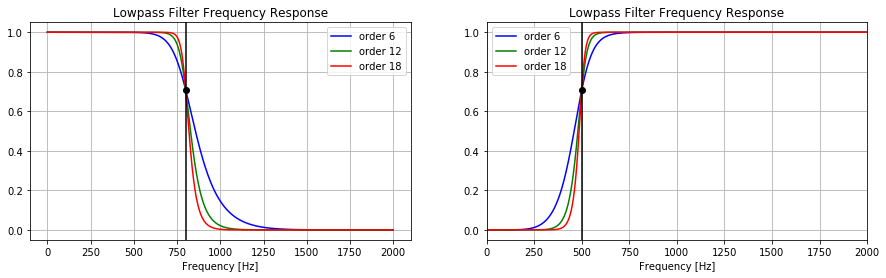

In [4]:
#######################################################
#                    low-pass filter
########################################################
plt.figure(figsize=(15, 4))
# Filter requirements.
fs = 4000.0   # sample rate, Hz
cutoff = 800  # desired cutoff frequency of the filter, Hz

# Plot the frequency response.
# Get the filter coefficients so we can check its frequency response.
order = 6
b, a = butter_lowpass(cutoff, fs, order)
w, h = freqz(b, a, worN=16000)
plt.subplot(1, 2, 1)
#plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')

order = 12
b, a = butter_lowpass(cutoff, fs, order)
w, h = freqz(b, a, worN=16000)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'g')

order = 18
b, a = butter_lowpass(cutoff, fs, order)
w, h = freqz(b, a, worN=16000)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'r')


plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
#plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.legend(['order 6','order 12','order 18'])
plt.grid()


#######################################################
#                    high-pass filter
########################################################
# Filter requirements.
fs = 4000.0       # sample rate, Hz
cutoff = 500  # desired cutoff frequency of the filter, Hz

# Plot the frequency response.
# Get the filter coefficients so we can check its frequency response.
order = 6
b, a = butter_highpass(cutoff, fs, order)
w, h = freqz(b, a, worN=8000)
plt.subplot(1, 2, 2)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')

order = 12
b, a = butter_highpass(cutoff, fs, order)
w, h = freqz(b, a, worN=8000)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'g')

order = 18
b, a = butter_highpass(cutoff, fs, order)
w, h = freqz(b, a, worN=8000)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'r')


plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.legend(['order 6','order 12','order 18'])
plt.grid()

plt.subplots_adjust(hspace=0.5)
plt.show()

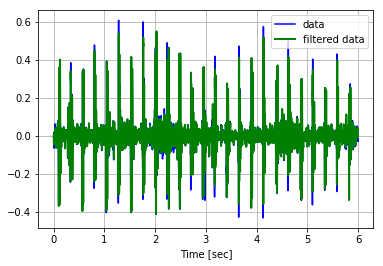

In [5]:
# Demonstrate the use of the filter.
data = selected_row.wav_raw
t    = np.linspace(0,round(len(data)/fs),len(data),endpoint=False)

# Filter the data, and plot both the original and filtered signals.
yLP = butter_lowpass_filter(data, cutoff, fs, order)
yHP = butter_highpass_filter(data, cutoff, fs, order)

plt.subplot(1, 1, 1)
plt.plot(t, data, 'b-', label='data')
plt.plot(t, yLP, 'g-', linewidth=2, label='filtered data')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()

plt.subplots_adjust(hspace=0.35)
plt.show()

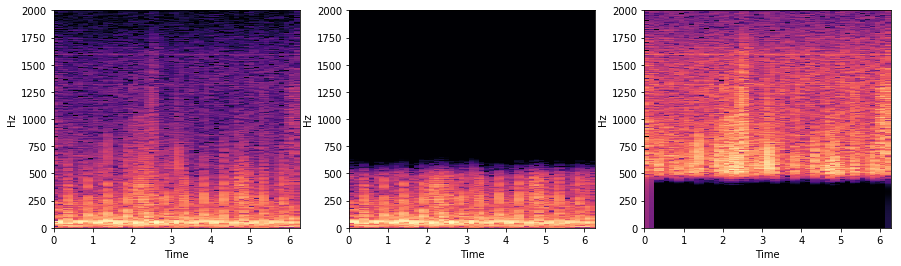

In [8]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
ref_max = np.max
D = librosa.amplitude_to_db(librosa.stft(data), ref=ref_max)
librosa.display.specshow(D, sr=fs, x_axis='time', y_axis='hz')

plt.subplot(1, 3, 2)
DL = librosa.amplitude_to_db(librosa.stft(yLP), ref=ref_max)
librosa.display.specshow(DL, sr=fs, x_axis='time', y_axis='hz')


plt.subplot(1, 3, 3)
DH = librosa.amplitude_to_db(librosa.stft(yHP), ref=ref_max)
librosa.display.specshow(DH, sr=fs, x_axis='time', y_axis='hz')

In [ ]:
librosa.